In the first part of the book, the author spends a lot of pages to explain how to prepare features and labels for training ML models. One of the part is about labeling. We briefly go through how to label data with my implementation.

In [1]:
import pandas as pd

df = pd.read_csv('data/MSFT.csv', index_col=0)
start = '2000-01-01'
end = '2018-01-01'
df.index = pd.DatetimeIndex(df.index)
df = df.loc[(df.index >= start) & (df.index <= end)]

In [2]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03,39.066089,39.482146,37.278708,38.796484,53228400.0
2000-01-04,37.797947,38.982878,37.361920,37.485073,54119000.0
2000-01-05,36.985804,38.733244,36.403324,37.881159,64059600.0
2000-01-06,37.341949,37.901130,36.070479,36.613017,54976600.0
2000-01-07,36.153690,37.361920,35.717662,37.092315,62013600.0


We use `Close` for labeling.

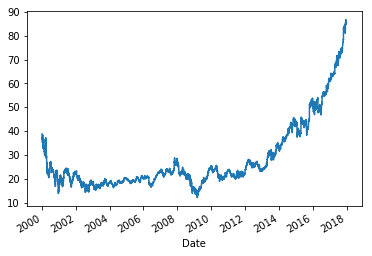

In [3]:
%matplotlib inline
close = df['Close']
close.plot();

By reducing data points, we are able to train more efficiently and effectively. One of the examples is CUSUM Filter. CUSUM Filter samples points when data points deviate from historical means.

DatetimeIndex(['2000-01-12', '2000-01-18', '2000-01-19', '2000-02-08',
               '2000-03-06', '2000-03-09', '2000-03-14', '2000-03-22',
               '2000-03-23', '2000-03-27',
               ...
               '2017-09-11', '2017-09-21', '2017-10-05', '2017-10-19',
               '2017-11-21', '2017-11-28', '2017-11-29', '2017-12-04',
               '2017-12-06', '2017-12-19'],
              dtype='datetime64[ns]', length=626, freq=None)


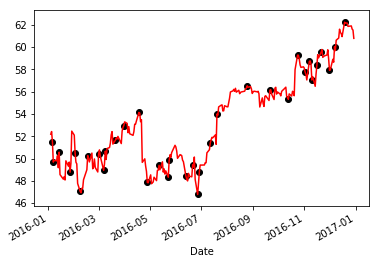

In [4]:
from finance_ml.stats import get_daily_vol
from finance_ml.labeling import cusum_filter
import matplotlib.pyplot as plt

h = 2 * close * get_daily_vol(close)
timestamps = cusum_filter(close, h)
print(timestamps)

start = '2016-01-01'
end = '2017-01-01'

close.loc[(close.index >= start) & (close.index <= end)].plot(color='r');
close_ = close.loc[timestamps]
close_ = close_.loc[(close_.index >= start) & (close_.index <= end)]
plt.scatter(close_.index, close_, color='k');

Next, we define triple barriers: 2 horizontal and 1 vertical.

In [5]:
from finance_ml.labeling import get_t1, get_events

t1 = get_t1(close, timestamps, 5)
print('*' * 100)
print(t1.head())
vol = get_daily_vol(close)
events = get_events(close, timestamps, [1, 1], vol, min_ret=0,
                    num_threads=16, t1=t1, side=None)

print('*' * 100)
print(events.head())

****************************************************************************************************
2000-01-12   2000-01-18
2000-01-18   2000-01-24
2000-01-19   2000-01-24
2000-02-08   2000-02-14
2000-03-06   2000-03-13
Name: Date, dtype: datetime64[ns]


2018-10-25 21:35:49.023962 100.0% get_touch_idx done after 0.01 minutes. Remaining 0.0 minutes.


****************************************************************************************************
                   t1      trgt type
2000-01-12 2000-01-14  0.020946   tp
2000-01-18 2000-01-19  0.026268   sl
2000-01-19 2000-01-24  0.033158   sl
2000-02-08 2000-02-09  0.029899   sl
2000-03-06 2000-03-08  0.027650   tp


Finally, we generate labels.

In [6]:
from finance_ml.labeling import get_t1, get_sizes

out = get_sizes(close, events, sign_label=False)
print(out.head())

                 ret  size
2000-01-12  0.060864   1.0
2000-01-18 -0.072067  -1.0
2000-01-19 -0.053738  -1.0
2000-02-08 -0.054029  -1.0
2000-03-06  0.054513   1.0


# Meta Labeling

We test metalabeling with randomly sampled sides. Metalabeling is a technique to separate deciding position side and betting size. For example, you can decide sides based on cross moving average and predicting size of betting by ML algorithms.

In [7]:
import numpy as np

side = pd.Series(np.random.choice([-1, 1], len(close)), index=close.index)

t1 = get_t1(close, timestamps, 5)
vol = get_daily_vol(close)
events = get_events(close, timestamps, [1, 1], vol, min_ret=0,
                    num_threads=16, t1=t1, side=side)
out = get_sizes(close, events, sign_label=False)
print(out.head())

2018-10-25 21:35:51.815619 100.0% get_touch_idx done after 0.01 minutes. Remaining 0.0 minutes.


                 ret  side  size
2000-01-12  0.060864     1   1.0
2000-01-18  0.072067    -1   1.0
2000-01-19 -0.053738     1   0.0
2000-02-08 -0.054029     1   0.0
2000-03-06 -0.054513    -1   0.0


/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


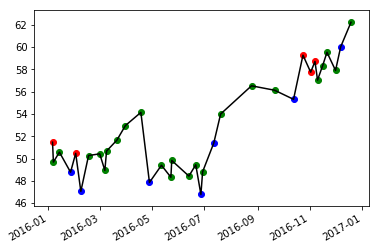

In [8]:
label = out['size'] * out['side']
start = '2016-01-01'
end = '2017-01-01'

label = label.loc[(label.index >= start) & (label.index <= end)]
pos_idx = label.loc[label == 1].index
neg_idx = label.loc[label == -1].index
zero_idx = label.loc[label == 0].index
close.loc[label.index].plot(color='k');
plt.scatter(pos_idx, close.loc[pos_idx], color='b');
plt.scatter(neg_idx, close.loc[neg_idx], color='r');
plt.scatter(zero_idx, close.loc[zero_idx], color='g');